# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Assignment 6: Ensemble Learning and Random Forests

## Learning Objectives

At the end of the experiment, you will be able to

* understand Ensemble learning and Ensemble methods
* perform Voting Classifier and Bagging Classifier using Scikit-Learn package
* understand the concept of Random Forest
* perform classification using RandomForestClassifier

### Introduction

Instead of using a single predictor if we aggregate the predictions of a group of predictors (such as classifiers or regressors), we will often get better predictions than with the best individual predictor. A group of predictors is called an ensemble, thus, this technique is called **Ensemble Learning**, and an Ensemble Learning algorithm is called an Ensemble method.

The most popular Ensemble methods include: 
* voting classifier
* bagging
* boosting 

Here, we will consider only voting classifier and bagging as well as an ensemble of Decision Trees called Random Forests.

### Setup Steps:

### Import required packages

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

### Voting Classifier

In this ensemble method, we train the training sample on different algorithms and aggregate their predictions.

Suppose we have trained a few classifiers, each one achieving about 80% accuracy. We may have a Logistic Regression classifier, an SVM classifier, a K-Nearest Neighbors classifier, and perhaps a few more as shown in the figure below.
<br><br>
<center>
<img src="https://cdn.iisc.talentsprint.com/CDS/Images/Voting_classifier_1.jpg" width= 600 px/>
</center>
<br><br>

Then to create an even better classifier we aggregate the predictions of each classifier and predict the class that gets the most votes as shown in the figure below. This majority-vote classifier is called a **hard voting** classifier.

<br><br>
<center>
<img src="https://cdn.iisc.talentsprint.com/CDS/Images/Voting_classifier_prediction.png" width= 600 px/>
</center><br><br>

Surprisingly, it is found that the voting classifier often achieves a higher accuracy than the best classifier in the ensemble. In fact, even if each classifier is a weak learner (performs only slightly better than random guessing), the ensemble can still be a strong learner and achieve high accuracy, provided there are a sufficient number of weak learners and they are sufficiently diverse.

We can use Scikit-Learn's **soft voting** to predict the class with the highest class probability, averaged over all the individual classifiers, provided that all the classifiers are able to estimate class probabilities (i.e., they have a `predict_proba()` method). It often achieves higher performance than hard voting because it gives more weight to highly confident votes.

**Exercise 1:** Generate a dataset having 4 classes and compare the accuracy for different models when used individually as well as when used within the Voting classifier.

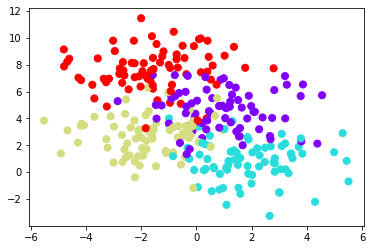

In [9]:
# Generate sample data
X, y = datasets.make_blobs(n_samples=300,                   # total number of points equally divided among clusters
                           centers=4,                       # number of centers to generate
                           cluster_std=1.5,                 # standard deviation of the clusters
                           random_state=0                   # determines random number generation for reproducible output
                                                            # across multiple function calls
                           )
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

In [12]:
# Splitting the Dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.30, random_state= 123)

# Instantiate LogisticRegression, KNN, SVC and VotingClassifier
log_clf = LogisticRegression()
knn_clf = KNN()
svm_clf = SVC(probability= True)
classifiers = [('lr', log_clf), ('knn', knn_clf), ('svc', svm_clf)]

voting_clf = VotingClassifier(estimators= classifiers, voting='soft')

for clf in (log_clf, knn_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8333333333333334
KNeighborsClassifier 0.7888888888888889
SVC 0.8444444444444444
VotingClassifier 0.8555555555555555


From the above result, we can see VotingClassifier has performed a little better than all of the other classifiers.

### Bagging and Pasting

In this ensemble method, instead of using different training algorithms, we use the same training algorithm to train on different random subsets of the training set.

When sampling is performed 
* with replacement, this method is called **bagging** (short for bootstrap aggregating).
* without replacement, it is called **pasting**. 

In other words, both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor as shown in the figure below.
<br><br>
<center>
<img src="https://i2.wp.com/thecleverprogrammer.com/wp-content/uploads/2020/07/un-115.png?resize=839%2C425&ssl=1" width= 600 px/>
</center>
<br><br>

Once all predictors are trained, the ensemble can make a prediction for a new
instance by simply aggregating the predictions of all predictors. 

The aggregation function is typically 
* the statistical mode (i.e., the most frequent prediction) for classification, or 
* the average for regression. 

Each individual predictor has a higher bias than if it were trained on the original training set, but aggregation reduces both bias and variance. Generally, the net result is that the ensemble has a similar bias but a lower variance than a single predictor trained on the original training set. 

**Exercise 2:** On the above created dataset perform classification using BaggingClassifier with DecisionTreeClassifier as base estimator.

In [15]:
dt = DecisionTreeClassifier()
bag_clf = BaggingClassifier( base_estimator=dt,     # base estimator to fit on random subsets of the dataset
                            n_estimators=300,       # number of base estimators in the ensemble
                            max_samples=100,        # number of samples to draw from X to train each base estimator. 
                                                    # If int, then draw max_samples samples.
                                                    # If float, then draw (max_samples * X.shape[0]) samples.
                            bootstrap=True,         # whether samples are drawn with replacement
                            random_state= 123       # seed used by the random number generator to ensure reproducibility
                            )
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print(bag_clf.__class__.__name__, accuracy_score(y_test, y_pred))

BaggingClassifier 0.8333333333333334


#### Out-of-Bag Evaluation

With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all. By default, a `BaggingClassifier` samples $m$ training instances with replacement (`bootstrap=True`), where $m$ is the size of the training set. This means that only about 63% of the training instances are sampled on average for each predictor. The remaining 37% of the training instances that are not sampled are called **out-of-bag (oob) instances**. Note that they are not the same 37% for all predictors. 

Since a predictor never sees the oob instances during training, it can be evaluated on these instances, without the need for a separate validation set. We can evaluate the ensemble itself by averaging out the oob evaluations of each predictor as shown in the figure below.
<br><br>
<center>
<img src="https://cdn.iisc.talentsprint.com/CDS/Images/OOB_evaluation.png" width= 600 px/>
</center>
<br><br>

In Scikit-Learn, we can set `oob_score = True` when creating a `BaggingClassifier` to request an automatic oob evaluation after training.

**Exercise 3:** Compute the OOB score for BaggingClassifier mentioned in Exercise 2.

In [16]:
dt = DecisionTreeClassifier()
bag_clf = BaggingClassifier( base_estimator=dt, 
                            n_estimators=300, 
                            max_samples=100, 
                            bootstrap=True, 
                            oob_score=True,              # use out-of-bag samples to estimate the generalization error
                            random_state= 123
                            )
bag_clf.fit(X_train, y_train)
bag_clf.predict(X_test)
print(f"OOB score: {bag_clf.oob_score_}")
print(bag_clf.__class__.__name__, accuracy_score(y_test, y_pred))

OOB score: 0.7666666666666667
BaggingClassifier 0.8333333333333334


According to the above oob evaluation score, this BaggingClassifier is likely to achieve about 77% accuracy on the test set. And we get above 80% accuracy on the test set that is close enough.

### Random Forests

A random forest is a collection of decision trees whose results are aggregated into one final result. Random Forest  is a supervised classification algorithm. There is a direct relationship between the number of trees in the forest and the results it can get: the larger the number of trees, the more accurate the result. But here creating the forest is not the same as constructing the decision tree with the information gain or gain index approach.

The difference between the Random Forest algorithm and the decision tree algorithm is that in Random Forest, the process of finding the root node and splitting the feature nodes will run randomly.


**Why Random Forest algorithm?**  Overfitting is one critical problem that may make the results worse, but for Random Forest algorithm, if there are enough trees in the forest, the classifier won’t overfit the model. The advantage is the classifier of Random Forest can handle missing values and can be used to model the categorical values.


**How does Random Forest algorithm work?** There are two stages in Random Forest algorithm, one is random forest creation, the other is to make a prediction from the random forest classifier created in the first stage. 

**Steps:**

1. Randomly select “k” features from total “m” features where k << m as shown in the figure below
2. Among the “k” features, calculate the node “d” using the best split point
3. Split the node into leaf nodes using the best split
4. Repeat the 1 to 3 steps until “l” number of nodes has been reached
5. Build forest by repeating steps 1 to 4 for “n” number times to create “n” number of trees.
6. Take the test features and use the rules of each randomly created decision tree to predict the outcome and stores the predicted outcome (target)
7. Calculate the votes for each predicted target
8. Consider the high voted predicted target as the final prediction from the random forest algorithm
<br><br>
<center>
<img src="https://cdn.iisc.talentsprint.com/CDS/Images/Random_forests.png" width = 600 px/>
</center>

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which trades a higher bias for a lower variance, generally yielding an overall better model.

With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself. 

To Know more about Random Forest classifier parameters, click [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

**Exercise 4:** On the above created dataset perform classification using RandomForestClassifier. Also provide its equivalent, using BaggingClassifier.

In [17]:
rf_clf = RandomForestClassifier(n_estimators=300,           # number of trees in the forest
                                max_leaf_nodes=16,          # grow trees with max_leaf_nodes, selected by 
                                                            # relative reduction in impurity. 
                                                            # If None, then unlimited number of leaf nodes
                                random_state= 123
                                )
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))

0.8333333333333334


The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`:

In [18]:
dt = DecisionTreeClassifier(splitter="random",               # strategy used to choose the split at each node. 
                                                             # "best" to choose the best split and 
                                                             # "random" to choose the best random split
                            max_leaf_nodes=16                 
                            )

bag_clf = BaggingClassifier(base_estimator=dt, n_estimators=300, max_samples=1.0, bootstrap=True,random_state=123)

bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
print(bag_clf.__class__.__name__, accuracy_score(y_test, y_pred_bag))

BaggingClassifier 0.8333333333333334


#### Feature Importance

Random Forests make it easy to measure the relative importance of each feature. Scikit-Learn measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average (across all trees in the forest). More precisely, it is a weighted average, where each node’s weight is equal to the number of training samples that are associated with it.

Scikit-Learn computes this score automatically for each feature after training, then it scales the results so that the sum of all importances is equal to 1. We can access the result using the `feature_importances_` instance variable. 

For example, the following code trains a RandomForestClassifier on the Iris dataset and outputs each feature’s importance.

**Exercise 5:** Extract the important features from Iris dataset using RandomForestClassifier.

sepal length (cm) 0.0938009573046062
sepal width (cm) 0.024076212819375907
petal length (cm) 0.45880520855709234
petal width (cm) 0.42331762131892564


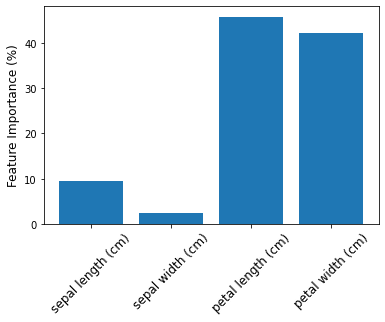

In [19]:
# Load iris dataset
iris = datasets.load_iris()
# Prediction and target features
prediction_features = iris["data"]
target_feature = iris["target"]
# Instantiate Random Forest classifier with n_estimators=500
rf_clf = RandomForestClassifier(n_estimators=500, 
                                random_state=123
                                )
# Fit on iris data
rf_clf.fit(prediction_features,target_feature)
for name, score in zip(iris["feature_names"], rf_clf.feature_importances_):
   print(name, score)

# Plot Feature importances
plt.bar(iris["feature_names"], rf_clf.feature_importances_ * 100)
plt.xticks(rotation=45, fontsize=12)
plt.ylabel("Feature Importance (%)", fontsize=12)
plt.show()

From the above result, it seems that the most important features are the petal length (45%) and petal width (42%), while sepal length and sepal width are rather unimportant in comparison (9% and 2%, respectively).

Let's see one exercise on real world dataset.

**Exercise 6:** Using `heart_failure_clinical_records_dataset`, build a classifier with Random forest to predict `DEATH_EVENT`. Also, extract the important features from this dataset and see if it affects the accuracy if only these features as used for prediction.

[Heart failure clinical records dataset](https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records) contains the medical records of 299 patients who had heart failure, collected during their follow-up period, where each patient profile has 13 clinical features given as:

- **age**: age of the patient (years)
- **anaemia**: decrease of red blood cells or hemoglobin (boolean)
- **high_blood_pressure**: if the patient has hypertension (boolean)
- **creatinine_phosphokinase (CPK)**: level of the CPK enzyme in the blood (mcg/L)
- **diabetes**: if the patient has diabetes (boolean)
- **ejection_fraction**: percentage of blood leaving the heart at each contraction (percentage)
- **platelets**: platelets in the blood (kiloplatelets/mL)
- **sex**: woman or man (binary)
- **serum_creatinine**: level of serum creatinine in the blood (mg/dL)
- **serum_sodium**: level of serum sodium in the blood (mEq/L)
- **smoking**: if the patient smokes or not (boolean)
- **time**: follow-up period (days)
- **DEATH_EVENT**: if the patient deceased during the follow-up period (boolean)

In [20]:
# Load dataset
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [22]:
# Shape of dataset
df.shape

(299, 13)

In [23]:
# Check for missing values
df.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

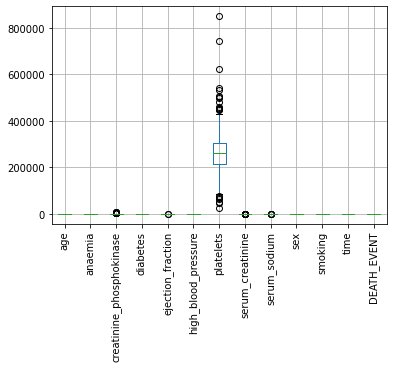

In [24]:
# Checking for outliers
df.boxplot()
plt.xticks(rotation=90)
plt.show()

In [25]:
# Handing outliers
outlier_colms = ['creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']
df1 = df.copy()

def handle_outliers(df, colm):
    '''Change the values of outlier to upper and lower whisker values '''
    q1 = df.describe()[colm].loc["25%"]
    q3 = df.describe()[colm].loc["75%"]
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    for i in range(len(df)):
        if df.loc[i,colm] > upper_bound:
            df.loc[i,colm]= upper_bound
        if df.loc[i,colm] < lower_bound:
            df.loc[i,colm]= lower_bound
    return df
    
for colm in outlier_colms:
    df1 = handle_outliers(df1, colm)

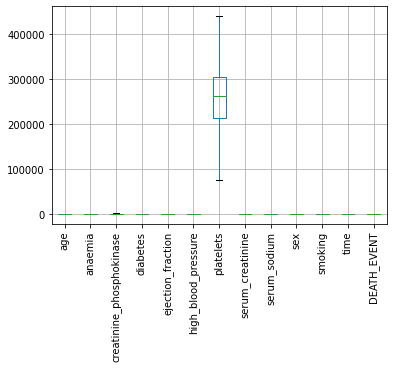

In [28]:
# Recheck for outliers
df1.boxplot()
plt.xticks(rotation=90)
plt.show()

In [29]:
# Split dataset into training and testing set, considering all features for prediction
X = df1.iloc[:, :-1].values
y = df1['DEATH_EVENT'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state= 123)

In [30]:
# Random Forest classifier
rf = RandomForestClassifier(n_estimators=400, random_state=123)
rf.fit(X_train, y_train)
test_acc = accuracy_score(y_test, rf.predict(X_test))
print("Testing accuracy: ", test_acc)

Testing accuracy:  0.8888888888888888


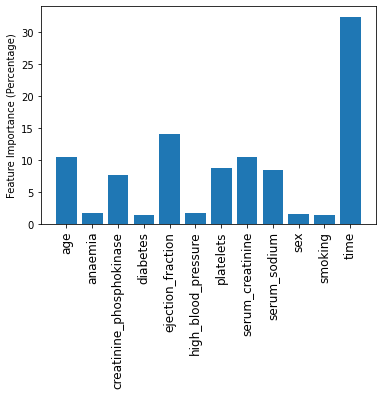

In [33]:
# Feature Importance plot
plt.bar(df1.columns[:-1], rf.feature_importances_ * 100)
plt.xticks(rotation=90, fontsize=12)
plt.ylabel("Feature Importance (Percentage)", size = 10)
plt.show()

In [34]:
# Considering features with importance > 0.08
colms = df1.columns[:-1][rf.feature_importances_ > 0.08]
print(colms)

Index(['age', 'ejection_fraction', 'platelets', 'serum_creatinine',
       'serum_sodium', 'time'],
      dtype='object')


In [35]:
# Split dataset into training and testing set, considering selected features only
X1 = df1[colms].values
y1 = df1['DEATH_EVENT'].values
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size = 0.3, stratify= y1, random_state= 123)

In [36]:
# Random Forest classifier
rf_ = RandomForestClassifier(n_estimators=400, random_state=123)
rf_.fit(X_train, y_train)
test_acc = accuracy_score(y_test,rf_.predict(X_test))
print("Testing accuracy: ", test_acc)

Testing accuracy:  0.9111111111111111


From the above results, we can see that accuracy is increased from 0.88 to 0.91 after training the Random Forest model on extracted features.

### Comparison between Bagging and Random Forest

|  Bagging  |  Random Forest  | 
|:--------------|:-----------|
|  One of the simplest ensemble-based algorithms applied to enhance predictive accuracy  | Enhanced version of bagging, ensemble of decision trees trained with a bagging mechanism |
|  We can specify the base estimator  | Uses Decision Tree as base estimator |
|  Every Decision Tree is taking all the features  | Each Decision Tree works on the subset of the features | 
|  Concept is to train a bunch of unpruned decision trees on different random subsets of the training data, sampling with replacement  | Concept is to build multiple decision trees and aggregate them to get an accurate result with as little bias as possible | 
|  Improves the accuracy and stability of ML models using ensemble learning and reduces the complexity of overfitting models  | It is very robust against overfitting and good with unbalanced and missing data | 

### Theory Questions

1. If you have trained five different models on the exact same training data, and they all achieve 95% precision, is there any chance that you can combine these models to get better results? If so, how? If not, why?

 If you have trained five different models and they all achieve 95% precision, you can try combining them into a voting ensemble, which will often give you even better results. It works better if the models are very different (e.g., an SVM classifier, a Decision Tree classifier, a Logistic Regression classifier, and so on). It is even better if they are trained on different training instances (that’s the whole point of bagging and pasting ensembles), but if not this will still be effective as long as the models are very different.


2. What is the difference between hard and soft voting classifiers?

 A hard voting classifier just counts the votes of each classifier in the ensemble and picks the class that gets the most votes. A soft voting classifier computes the average estimated class probability for each class and picks the class with the highest probability. This gives high-confidence votes more weight and often performs better, but it works only if every classifier is able to estimate class probabilities (e.g., for the SVM classifiers in Scikit-Learn you must set probability=True).


3. Is it possible to speed up training of a bagging ensemble by distributing it across multiple servers? What about pasting ensembles, boosting ensembles, or Random Forests?

 It is quite possible to speed up training of a bagging ensemble by distributing it across multiple servers, since each predictor in the ensemble is independent of the others. The same goes for pasting ensembles and Random Forests, for the same reason. However, each predictor in a boosting ensemble is built based on the previous predictor, so training is necessarily sequential, and you will not gain anything by distributing training across multiple servers.


4. What is the benefit of out-of-bag evaluation?

 With out-of-bag evaluation, each predictor in a bagging ensemble is evaluated
using instances that it was not trained on (they were held out). This makes it possible to have a fairly unbiased evaluation of the ensemble without the need for an additional validation set. Thus, you have more instances available for training, and your ensemble can perform slightly better.


5. What makes Extra-Trees more random than regular Random Forests? How can
this extra randomness help? Are Extra-Trees slower or faster than regular Random Forests?

 When you are growing a tree in a Random Forest, only a random subset of the
features is considered for splitting at each node. This is true as well for ExtraTrees, but they go one step further: rather than searching for the best possible thresholds, like regular Decision Trees do, they use random thresholds for each feature. This extra randomness acts like a form of regularization: if a Random Forest overfits the training data, Extra-Trees might perform better. Moreover, since Extra-Trees don’t search for the best possible thresholds, they are much faster to train than Random Forests. However, they are neither faster nor slower than Random Forests when making predictions. You can create an Extra-Trees classifier using Scikit-Learn’s `ExtraTreesClassifier` class. Its API is identical to the `RandomForestClassifier` class. 